<a id='toc'></a>

# Table of content
Dataset: <br>
https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

[Conclusions](#conclusions)

- [Libraries](#libraries)
- [Exploration analysis](#exploration_analysis)

<a id='conclusions'></a>

# Conclusions

**`1.`** xxx

**`2.`** xxx

**`3.`** xxx

<a id='libraries'></a>

# Libraries

In [89]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [90]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scikitplot as skplt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB # metoda częstościowa
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler, QuantileTransformer
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from time import time

random_state=42

In [109]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict

<a id='Import_dataset'></a>

# Import dataset

In [92]:
# import danych i podgląd
df = pd.read_csv('winequality-red.csv')
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df_2 = df.copy()
df_2['quality']= [0 if x <= 4 else 1 if x <= 5 else 2 if x <=6 else 3 for x in df_2['quality']]
# df_2['quality']= [0 if x <= 4 else 1 if x <=6 else 2 for x in df_2['quality']]
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1354,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1355,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1356,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1357,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [93]:
# different scallers might perform better
scalers = {'standard_scaler' : StandardScaler(),
           'max_abs_scaler' : MaxAbsScaler(),
           'robust_scaler' : RobustScaler(),
           'quantile_transformer_normal' : QuantileTransformer(output_distribution='normal'),
           'power_transformer_YeoJohnson' : PowerTransformer(method='yeo-johnson')}

In [94]:
# get number of classes for XGBoost classifier
num_of_classes = len(df_2['quality'].unique())

# get weight of each class for XGBoost classifier
target = df_2['quality']
class_0_proportion = len(target[target==0]) / len(target)
class_1_proportion = len(target[target==1]) / len(target)
class_2_proportion = len(target[target==2]) / len(target)
class_3_proportion = len(target[target==3]) / len(target)

print(class_0_proportion, class_1_proportion, class_2_proportion, class_3_proportion)

class_0_weight = class_0_proportion / class_0_proportion
class_1_weight = class_0_proportion / class_1_proportion
class_2_weight = class_0_proportion / class_2_proportion
class_3_weight = class_0_proportion / class_3_proportion

print(class_0_weight, class_1_weight, class_2_weight, class_3_weight)

weights_dictionary = {0: class_0_weight, 1: class_1_weight, 2: class_2_weight, 3: class_3_weight}
# classes_weights = [weights_dictionary[value] for value in y_train]

0.046357615894039736 0.42457689477557026 0.3936718175128771 0.13539367181751288
1.0 0.10918544194107453 0.1177570093457944 0.34239130434782605


In [95]:
# XGBoost weghts migh be applied at training step - results of XGBoost might be uncomparable at this stage
basic_models = {'LogistricRegression': LogisticRegression(random_state=random_state, class_weight='balanced',max_iter=10000),
                'RandomForestClassifier': RandomForestClassifier(random_state=random_state, class_weight='balanced'),
                'SVMClassifier': OneVsRestClassifier(SVC(random_state=random_state, class_weight='balanced')),
                'XGBoostClassifier': XGBClassifier(random_state=random_state, eval_metric='error', objective='multi:softprob', num_class=len(df_2['quality'].unique())),
                'KNeighborsClassifier' : KNeighborsClassifier()}

In [96]:
# split data into training/validation and test
X = df_2.iloc[:, :-1]
y = df_2.iloc[:, -1:].to_numpy().ravel()
test_size = .2
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_size,
                                                    random_state=random_state,
                                                    stratify=y)

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

In [137]:
pipeline_result = Pipeline([('scaler', StandardScaler()),
                            ('model', basic_models["XGBoostClassifier"])])

y_train_pred = cross_val_predict(pipeline_result, X_train, y_train, cv=skf)
cf = confusion_matrix(y_train, y_train_pred)
print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))

recall_0 = cf[0][0] / sum(cf[0, :])
precision_1 = cf[1][1] / sum(cf[:, 1])
precision_2 = cf[2][2] / sum(cf[:, 2])
recall_3 = cf[3][3] / sum(cf[3, :])

print(recall_0, precision_1, precision_2, recall_3)
print(recall_score(y_train, y_train_pred, average="macro"))
custom_score = (recall_0*1 + precision_1*0.75 + precision_2*0.75 + recall_3*0.9)/4
print(f"test_metric: {custom_score}")



              precision    recall  f1-score   support

           0       0.38      0.10      0.16        50
           1       0.66      0.71      0.68       462
           2       0.53      0.57      0.55       428
           3       0.50      0.38      0.43       147

    accuracy                           0.58      1087
   macro avg       0.52      0.44      0.46      1087
weighted avg       0.57      0.58      0.57      1087

[[  5  29  16   0]
 [  6 328 121   7]
 [  2 132 246  48]
 [  0  10  81  56]]
0.1 0.657314629258517 0.5301724137931034 0.38095238095238093
0.44141886151231946
test_metric: 0.3333681062864645


In [106]:
pipeline_result = Pipeline([('scaler', StandardScaler()),
                            ('model', basic_models["KNeighborsClassifier"])])


a = X_train # X_train X_test
y_true = y_train  # y_train y_test

pipeline_result.fit(X_train, y_train)
y_pred = pipeline_result.predict(a)

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.24      0.33        50
           1       0.71      0.80      0.75       462
           2       0.65      0.68      0.67       428
           3       0.73      0.50      0.59       147

    accuracy                           0.68      1087
   macro avg       0.65      0.55      0.58      1087
weighted avg       0.68      0.68      0.68      1087

[[ 12  22  15   1]
 [  7 368  83   4]
 [  4 112 290  22]
 [  0  18  56  73]]


In [70]:
cv_metrics = pd.DataFrame()
f1_scores = []
precision_scores = []
recall_scores = []
custom_scores = []

recall_scorer = make_scorer(recall_score, average='macro')
precision_scorer = make_scorer(precision_score, average='macro')
f1_scorer = make_scorer(f1_score, average='macro')

# recall_scorer_0 = make_scorer(recall_score, pos_label=0)
# precision_scorer_1 = make_scorer(precision_score, pos_label=1)
# precision_scorer_2 = make_scorer(precision_score, pos_label=2)
# recall_scorer_3 = make_scorer(recall_score, pos_label=3)

    
for model_name, model in basic_models.items():
    for scaler_name, scaler in scalers.items():
        
        start = time()
        # ---------- metrics calculation starts
        
        pipeline_result = Pipeline([('scaler', scaler),
                                    ('model', model)])

        f1 = cross_val_score(pipeline_result, X_train, y_train, scoring=f1_scorer, cv=skf)
        f1_scores.append(f1)
        f1_avg = round(f1.mean(),4)
        
        precision = cross_val_score(pipeline_result, X_train, y_train, scoring=precision_scorer, cv=skf)
        precision_scores.append(precision)
        precision_avg = round(precision.mean(),4)

        recall = cross_val_score(pipeline_result, X_train, y_train, scoring=recall_scorer, cv=skf)
        recall_scores.append(recall)
        recall_avg = round(recall.mean(),4)
        end = time()
        cross_val_time = end-start
        
        # custom scorer (numbers from beggining of the maetric represents classes):
        # (0_recall + 1_precision + 2_precision + 3_recall) / 4
        
        # list_of_custom_metrics=[cross_val_score(pipeline_result, X_train, y_train, scoring=recall_scorer_0, cv=skf),
        #                         cross_val_score(pipeline_result, X_train, y_train, scoring=precision_scorer_1, cv=skf),
        #                         cross_val_score(pipeline_result, X_train, y_train, scoring=precision_scorer_2, cv=skf),
        #                         cross_val_score(pipeline_result, X_train, y_train, scoring=recall_scorer_3, cv=skf)]
        # custom = np.mean(list_of_custom_metrics)
        # custom_scores.append(custom)
        # custom_avg = round(custom.mean(),2)

    
        # ---------- metrics calculation ends
        end = time()
        cross_val_time = end-start                
        
        cv_metrics[str(model_name + '_' +scaler_name)] = [f1_avg,
                                                          precision_avg,
                                                          recall_avg,
                                                        #   custom_avg,
                                                          model_name,
                                                          scaler_name,
                                                          cross_val_time]
        
cv_metrics.index = ['F1', 'Precision', 'Recall', 'Model', 'Scaler', 'Time']
cv_metrics.T.sort_values(by="F1", ascending=False)

,F1,Precision,Recall,Model,Scaler,Time
SVMClassifier_standard_scaler,0.4857,0.4805,0.5001,SVMClassifier,standard_scaler,1.679999
SVMClassifier_quantile_transformer_normal,0.4852,0.4831,0.493,SVMClassifier,quantile_transformer_normal,2.0841
SVMClassifier_robust_scaler,0.4818,0.4794,0.4924,SVMClassifier,robust_scaler,1.814008
SVMClassifier_power_transformer_YeoJohnson,0.4755,0.4734,0.4827,SVMClassifier,power_transformer_YeoJohnson,2.09429
XGBoostClassifier_quantile_transformer_normal,0.4593,0.5427,0.4436,XGBoostClassifier,quantile_transformer_normal,5.99993
XGBoostClassifier_standard_scaler,0.4567,0.5399,0.4413,XGBoostClassifier,standard_scaler,4.298755
XGBoostClassifier_robust_scaler,0.4496,0.5272,0.4364,XGBoostClassifier,robust_scaler,5.141846
XGBoostClassifier_power_transformer_YeoJohnson,0.4493,0.5266,0.4364,XGBoostClassifier,power_transformer_YeoJohnson,6.088325
XGBoostClassifier_max_abs_scaler,0.4488,0.526,0.4358,XGBoostClassifier,max_abs_scaler,5.442365
RandomForestClassifier_power_transformer_YeoJohnson,0.4478,0.5497,0.4361,RandomForestClassifier,power_transformer_YeoJohnson,2.424672


In [77]:
SVM_pipeline_result = Pipeline([('scaler', StandardScaler()),
                                ('model', OneVsRestClassifier(SVC(random_state=random_state, class_weight='balanced')))])
SVM_model = SVM_pipeline_result.named_steps['model'].fit(X_train, y_train)
SVM_y_train_pred = SVM_model.predict(X_train)

print(classification_report(y_train, SVM_y_train_pred))

              precision    recall  f1-score   support

           0       0.16      0.36      0.22        50
           1       0.67      0.38      0.48       462
           2       0.48      0.51      0.49       428
           3       0.29      0.50      0.37       147

    accuracy                           0.45      1087
   macro avg       0.40      0.44      0.39      1087
weighted avg       0.52      0.45      0.46      1087



In [78]:
SVM_y_train_pred

array([2, 2, 2, ..., 1, 0, 2], dtype=int64)

# old data

RobustScaler()
StandardScaler()
MaxAbsScaler()


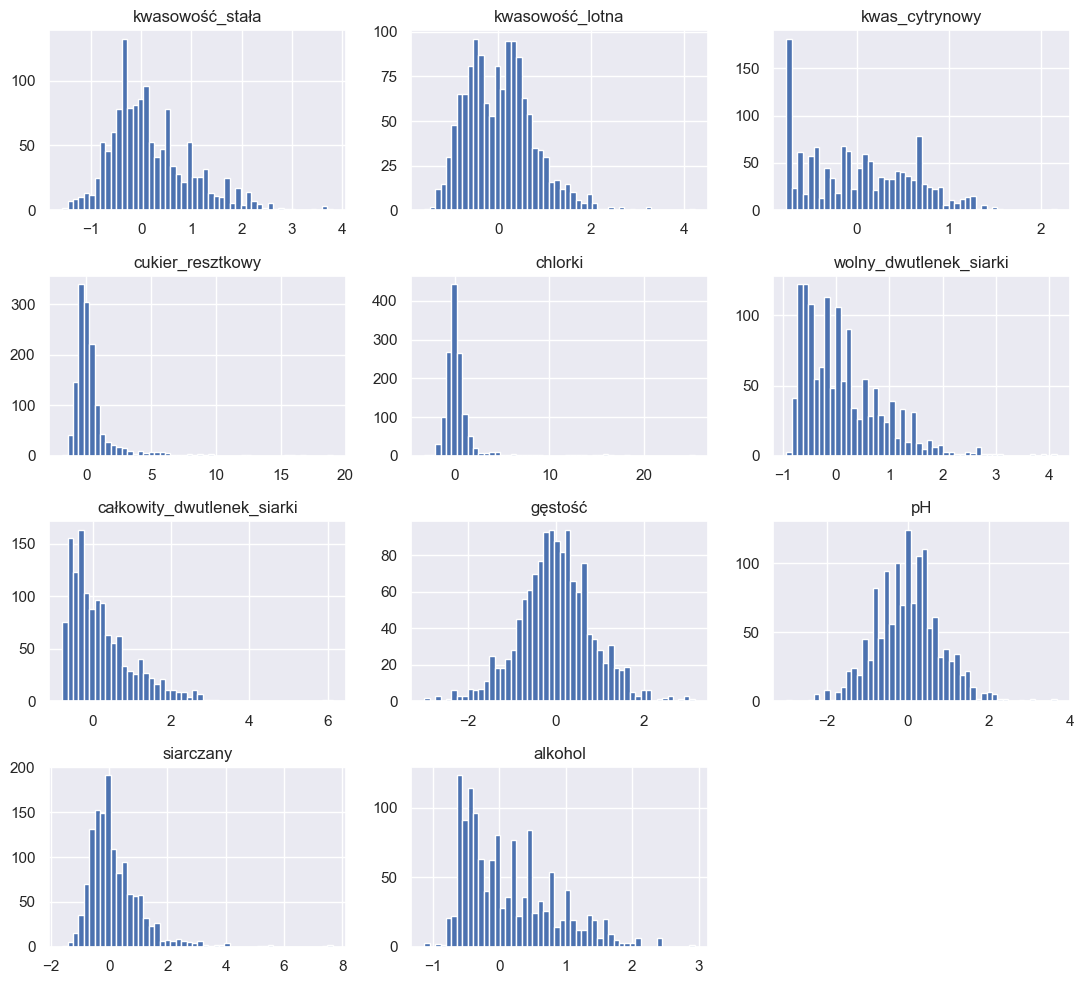

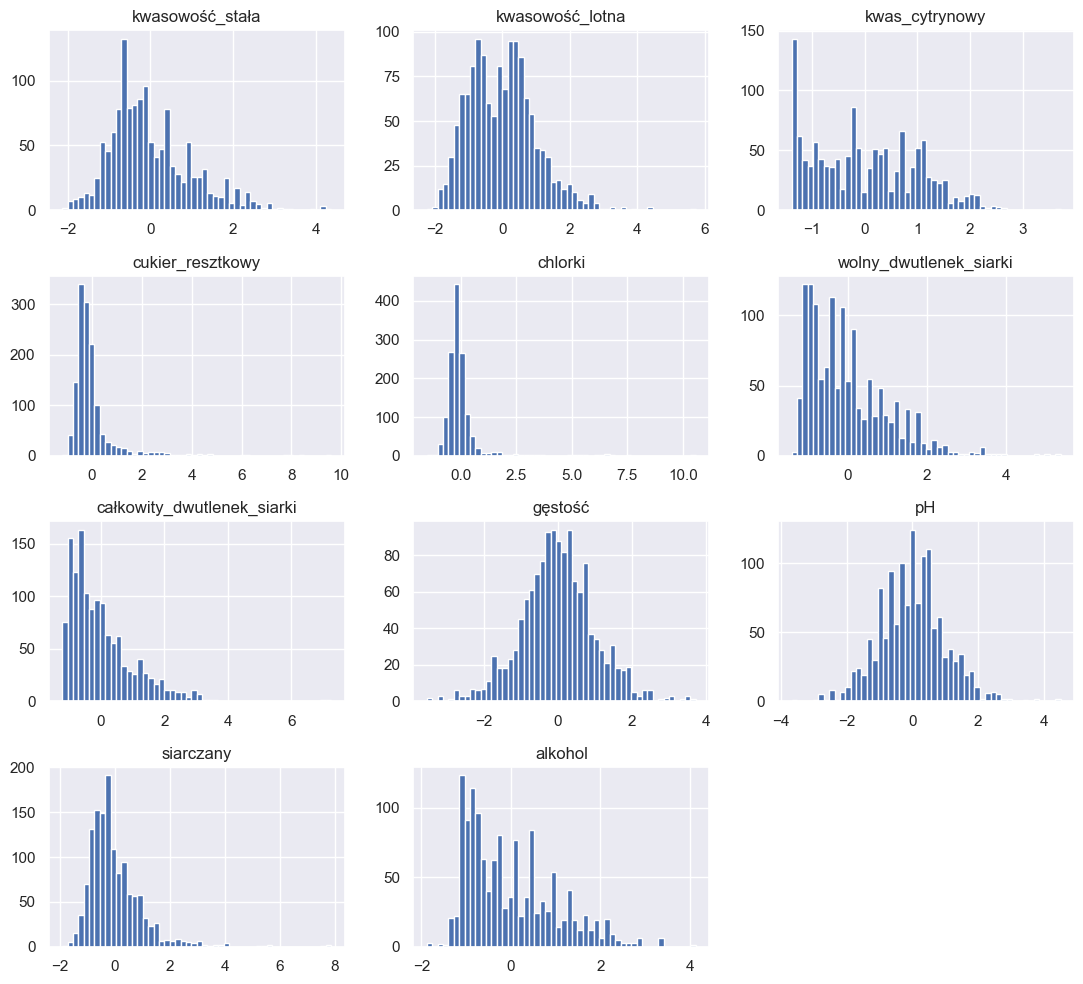

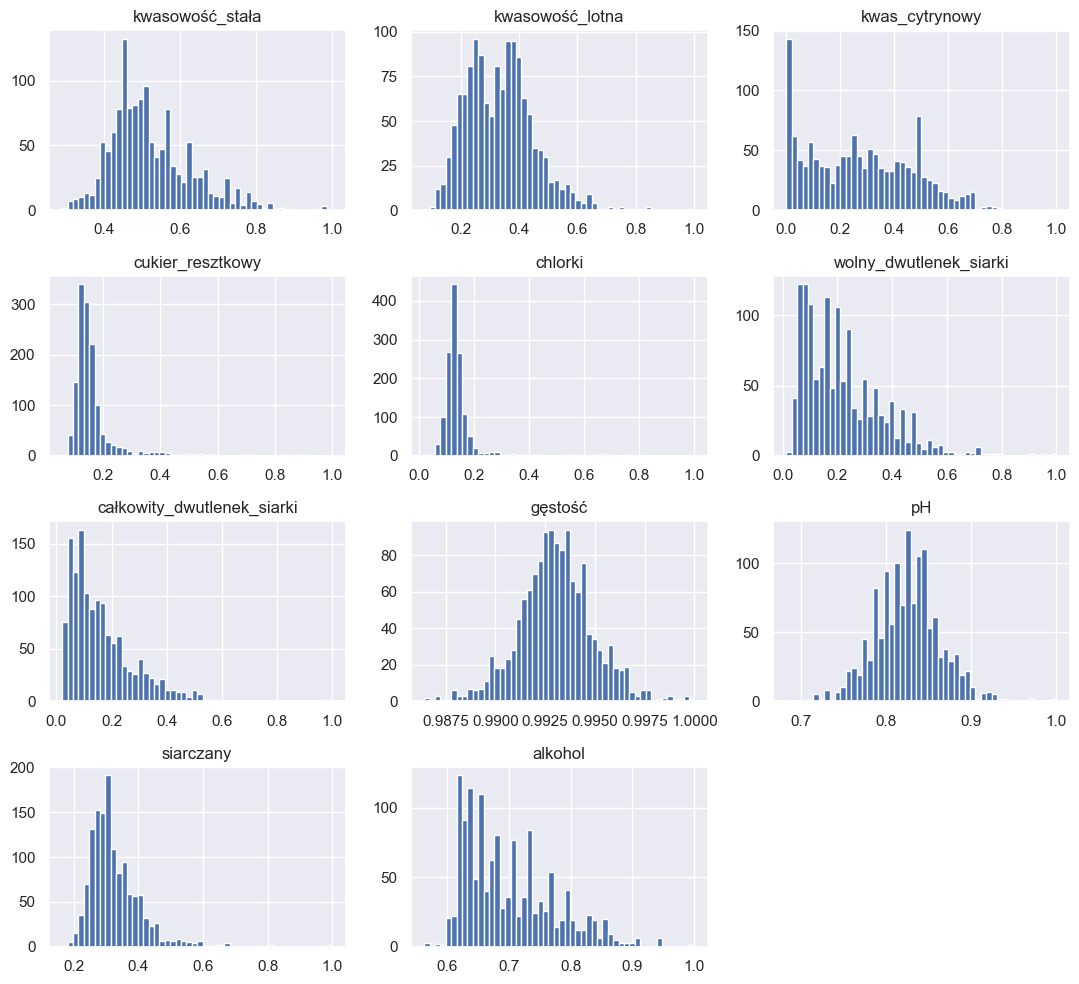

In [33]:
# visualization histogram after scalling
for scaler in scalers_list:
    df_features_copy = df.iloc[:, :-1].copy()
    df_scaled = scaler.fit_transform(df_features_copy)
    df_scaled = pd.DataFrame(df_scaled, columns=df_features_copy.columns)
    df_scaled.hist(bins=50, figsize=(11,10))
    print(f"{scaler}")
    plt.tight_layout();

There is no need for scalling the data in decision tree model. Data after scalling looks very similar what can be observed before scalling. Moreover decision tree can perform well without scalling

In [34]:
# check if scalling improve fbeta or f1 score
df_features_copy = df.iloc[:, :-1].copy()
df_scaled = standard_scaler.fit_transform(df_features_copy)
df_scaled = pd.DataFrame(df_scaled, columns=df_features_copy.columns)

X_scaled = df_scaled

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=test_size,
                                                    random_state=random_state,
                                                    stratify=df["jakość"])

In [35]:
# check if scalling improve fbeta or f1 score
for model in models:
    run_model(model, X_train_scaled, y_train, skf)

DecisionTreeClassifier || fbeta: 0.38, f1: 0.37, recall: 0.38, precision: 0.37, time: 0.13
RandomForestClassifier || fbeta: 0.45, f1: 0.47, recall: 0.45, precision: 0.56, time: 3.37
XGBClassifier || fbeta: 0.44, f1: 0.44, recall: 0.43, precision: 0.47, time: 7.45
KNeighborsClassifier || fbeta: 0.43, f1: 0.45, recall: 0.43, precision: 0.49, time: 0.31


Best model does not imporved due to scalling. KNeighbours imporoved, but Fbeta and f1 is still below level from Decision Tree Model

<a id='Optimalization'></a>

# Optimalization

In [36]:
# tuning the model
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)
fbeta_scorer = make_scorer(fbeta_score, beta=2, average='macro')

parameters_DT = {"class_weight": [None, {1:10, 2:1, 3:1, 4:10}, {1:20, 2:1, 3:1, 4:20}, "balanced"],
              "criterion": ["gini", "entropy"],
              "max_depth": np.arange(1, 15),
              "min_samples_split": np.arange(1, 5),
              "min_samples_leaf": np.arange(1, 5),
              "max_features": [None, "sqrt", "log2"],
              "splitter": ["best", "random"]}

grid_obj_DT = GridSearchCV(estimator=DT_model,
                           param_grid=parameters_DT,
                           scoring=fbeta_scorer,
                           cv=skf)

grid_fit_DT = grid_obj_DT.fit(X_train, y_train)

In [37]:
# get weight of each class for XGBoost classifier
class_1_proportion = len(y[y==1]) / len(y)
class_2_proportion = len(y[y==2]) / len(y)
class_3_proportion = len(y[y==3]) / len(y)
class_4_proportion = len(y[y==4]) / len(y)

print(class_1_proportion, class_2_proportion, class_3_proportion, class_4_proportion)

class_1_weight = class_1_proportion / class_1_proportion
class_2_weight = class_1_proportion / class_2_proportion
class_3_weight = class_1_proportion / class_3_proportion
class_4_weight = class_1_proportion / class_4_proportion

print(class_1_weight, class_2_weight, class_3_weight, class_4_weight)

weights_dictionary = {1: class_1_weight, 2: class_2_weight, 3: class_3_weight, 4: class_4_weight}
y_train_weights = [weights_dictionary[value] for value in y_train]

0.046357615894039736 0.42457689477557026 0.3936718175128771 0.13539367181751288
1.0 0.10918544194107453 0.1177570093457944 0.34239130434782605


In [38]:
# check if weights are properly assigned
y_and_weights = pd.DataFrame({'y': y_train, 'y_weights': y_train_weights})
y_and_weights.sample(10)

,y,y_weights
478,2,0.109185
199,3,0.117757
733,4,0.342391
36,4,0.342391
552,3,0.117757
767,3,0.117757
323,2,0.109185
394,3,0.117757
352,2,0.109185
276,2,0.109185


In [39]:
# tuning the model - XGB classifier
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)
fbeta_scorer = make_scorer(fbeta_score, beta=2, average='macro')

parameters_XGB = {"max_depth": np.arange(2, 10),
                  'n_estimators': range(60, 220, 40),
                  'learning_rate': [0.1, 0.01, 0.05]}

grid_obj_XGB = GridSearchCV(estimator=XGB_model,
                        param_grid=parameters_XGB,
                        scoring=fbeta_scorer,
                        cv=skf)

grid_fit_XGB = grid_obj_XGB.fit(X_train, y_train, sample_weight=y_train_weights) # implementing weights for each class

In [40]:
# Get the estimator
best_clf_DT = grid_fit_DT.best_estimator_
best_clf_XGB = grid_fit_XGB.best_estimator_

y_pred_DT = best_clf_DT.predict(X_test)
y_pred_XGB = best_clf_XGB.predict(X_test)

In [41]:
# Metrics before and after tuning
print("Unoptimized DT Model: fbeta = {:.2f}".format(fbeta_DT))
print("Optimized DT Model: fbeta = {:.2f}".format(fbeta_score(y_test, y_pred_DT, beta = 2, average='macro')), end="\n\n")

print("Unoptimized XGBoost Model: fbeta = {:.2f}".format(fbeta_XGB))
print("Optimized XGBoost Model: fbeta = {:.2f}".format(fbeta_score(y_test, y_pred_XGB, beta = 2, average='macro')))

Unoptimized DT Model: fbeta = 0.41
Optimized DT Model: fbeta = 0.40

Unoptimized XGBoost Model: fbeta = 0.47
Optimized XGBoost Model: fbeta = 0.51


DT
fbeta score = 0.41

              precision    recall  f1-score   support

           1       0.20      0.19      0.20        21
           2       0.59      0.56      0.58       193
           3       0.47      0.46      0.46       178
           4       0.37      0.44      0.40        61

    accuracy                           0.49       453
   macro avg       0.41      0.41      0.41       453
weighted avg       0.49      0.49      0.49       453



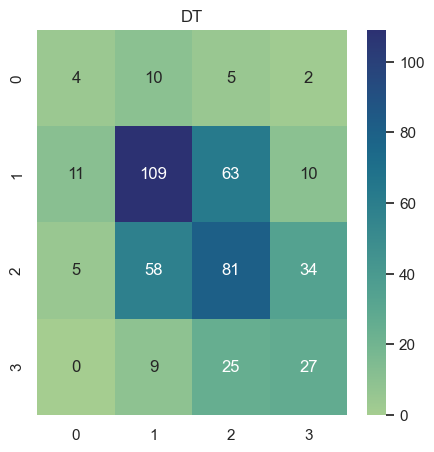

In [42]:
print("DT")
print(f"fbeta score = {fbeta_score(y_test, DT_model.predict(X_test), beta=2, average='macro'):.2f}", end="\n\n")
print(classification_report(y_test, DT_model.predict(X_test)))

fig = plt.figure(figsize=(5,5))
cm = confusion_matrix(y_test, DT_model.predict(X_test))
ax= plt.subplot()
sns.set(font_scale=1)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            ax=ax,
            cmap="crest")
plt.title("DT");

Best DT estimator after tuning
fbeta score = 0.40

              precision    recall  f1-score   support

           1       0.12      0.43      0.19        21
           2       0.60      0.54      0.57       193
           3       0.47      0.21      0.29       178
           4       0.32      0.66      0.43        61

    accuracy                           0.42       453
   macro avg       0.38      0.46      0.37       453
weighted avg       0.49      0.42      0.42       453



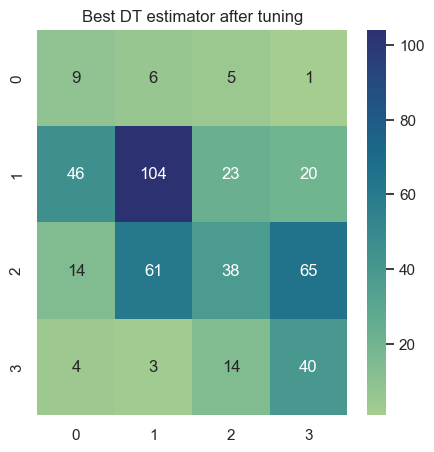

In [43]:
print("Best DT estimator after tuning")
print(f"fbeta score = {fbeta_score(y_test, best_clf_DT.predict(X_test), beta=2, average='macro'):.2f}", end="\n\n")
print(classification_report(y_test, best_clf_DT.predict(X_test)))

fig = plt.figure(figsize=(5,5))
cm = confusion_matrix(y_test, best_clf_DT.predict(X_test))
ax= plt.subplot()
sns.set(font_scale=1)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            ax=ax,
            cmap="crest")
plt.title("Best DT estimator after tuning");

XGB
fbeta score = 0.47

              precision    recall  f1-score   support

           1       0.33      0.14      0.20        21
           2       0.67      0.67      0.67       193
           3       0.52      0.56      0.54       178
           4       0.54      0.49      0.51        61

    accuracy                           0.58       453
   macro avg       0.51      0.47      0.48       453
weighted avg       0.58      0.58      0.58       453



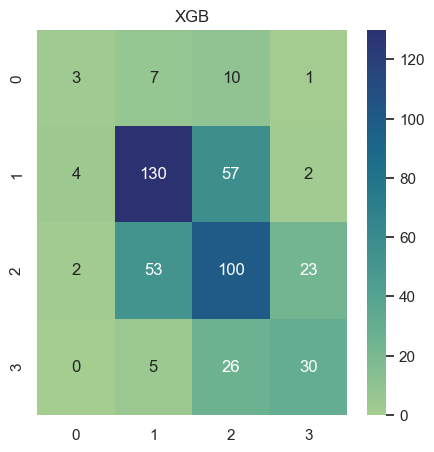

In [44]:
print("XGB")
print(f"fbeta score = {fbeta_score(y_test, XGB_model.predict(X_test), beta=2, average='macro'):.2f}", end="\n\n")
print(classification_report(y_test, XGB_model.predict(X_test)))

fig = plt.figure(figsize=(5,5))
cm = confusion_matrix(y_test, XGB_model.predict(X_test))
ax= plt.subplot()
sns.set(font_scale=1)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            ax=ax,
            cmap="crest")
plt.title("XGB");

Best XGB estimator after tuning
fbeta score = 0.51

              precision    recall  f1-score   support

           1       0.20      0.33      0.25        21
           2       0.68      0.59      0.63       193
           3       0.52      0.47      0.50       178
           4       0.48      0.70      0.57        61

    accuracy                           0.55       453
   macro avg       0.47      0.53      0.49       453
weighted avg       0.57      0.55      0.55       453



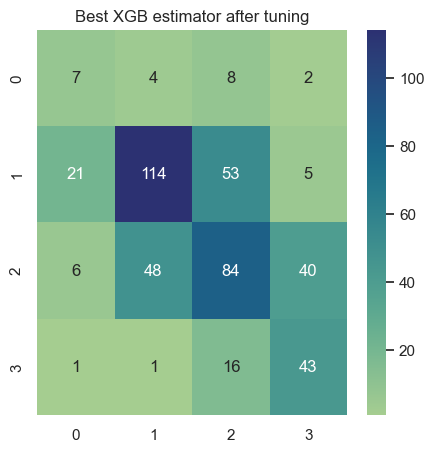

In [45]:
print("Best XGB estimator after tuning")
print(f"fbeta score = {fbeta_score(y_test, best_clf_XGB.predict(X_test), beta=2, average='macro'):.2f}", end="\n\n")
print(classification_report(y_test, best_clf_XGB.predict(X_test)))

fig = plt.figure(figsize=(5,5))
cm = confusion_matrix(y_test, best_clf_XGB.predict(X_test))
ax= plt.subplot()
sns.set(font_scale=1)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            ax=ax,
            cmap="crest")
plt.title("Best XGB estimator after tuning");

Turned out that even though Decision Tree basic model perfomerd better than basic XGBoost model, Decision Tree was resistant to class weights. XGBoost perfomerd better after implementhing sample_weight parameter, and fbeta score increased up to 0.59 compared to Decision Tree basic model 